In [28]:
import numpy as np
import pandas as pd
import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# load file
train_images = glob.glob("./data/train/*jpg")
test_images = glob.glob("./demo_data/test/*jpg")
df = pd.read_csv("./data/train.csv")

df["Image"] = df["Image"].map( lambda x : "./data/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [30]:
print(len(train_images))
print(len(test_images))

9850
100


In [31]:
SIZE = 128
#image are imported with a resizing and a black and white conversion
def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize((SIZE,SIZE)) #.convert("RGB")
    return np.array(img)[:,:,0]
train_img = np.load("./demo_data/processed_image.npy")
# train_img = np.array([ImportImage(img) for img in train_images])
x = train_img

In [32]:
# printing data set
print( "%d training images" %x.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in df["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

9850 training images
Nbr of samples/class	Nbr of classes
1			2220
2			1034
3			492
4			192
5			102
6			61
7			40
8			23
9			21
10			9
11			7
12			7
13			9
14			5
15			4
16			5
17			4
18			2
19			2
20			1
21			3
22			3
23			1
26			1
27			1
34			1
810			1


In [33]:
print (x.shape)
print (type(x))

(9850, 128, 128)
<type 'numpy.ndarray'>


In [34]:
# transfer label to one-hot

class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform(x)
        return self.ohe.fit_transform(features.reshape(-1,1))
    def transform(self, x):
        return self.ohe.transform(self.la.transform(x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform(self.ohe.inverse_tranform(x))
    def inverse_labels(self, x):
        return self.le.inverse_transform(x)
    
y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)
print (y_cat.shape)

(9850, 4251)


In [35]:
# constructing class weights
# due to imbalanced dataset
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform([[x]])
CountDict = dict(df["Id"].value_counts())
class_weight_dic = {lohe.le.transform([image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict

(9850, 128, 128)


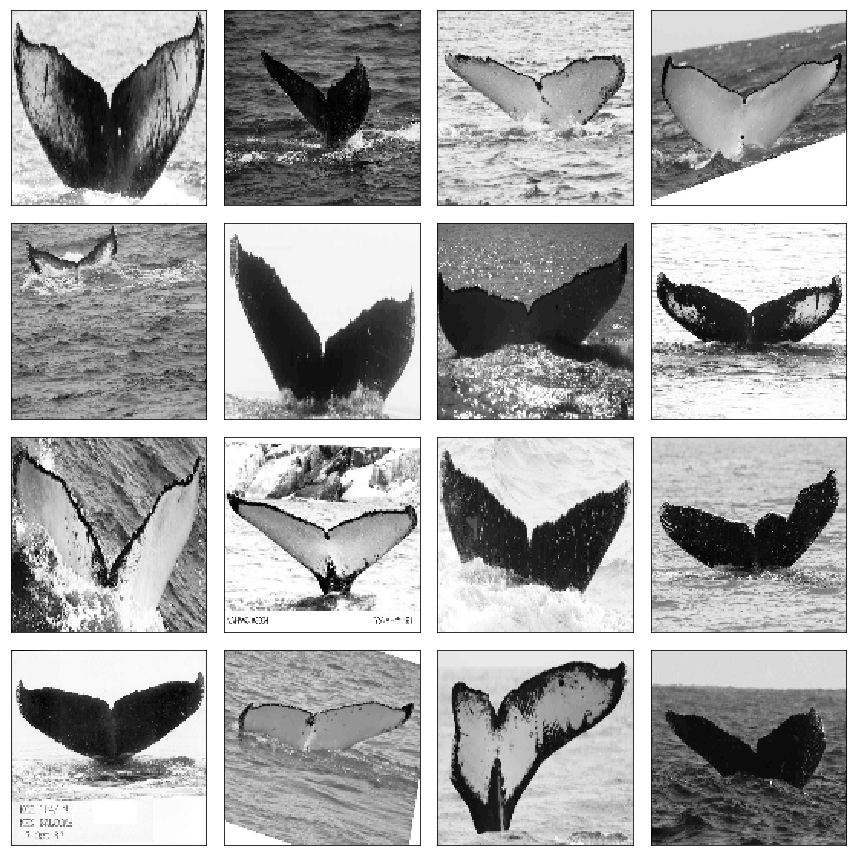

In [36]:
# visualization
def plotImages(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((SIZE,SIZE,1))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
#plotting training images from training set after resizing and BW conversion
print(x.shape)
plotImages(x)

In [37]:
#use of an image generator for preprocessing and data augmentation
x = x.reshape((-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

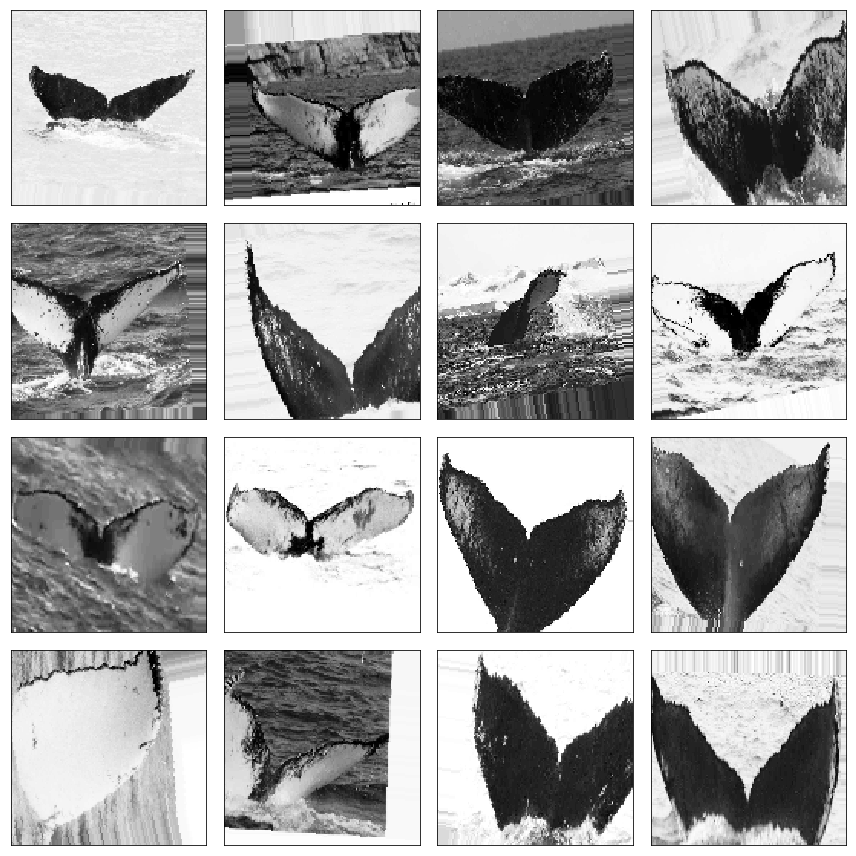

In [38]:
#visualization of some images out of the preprocessing
augmented_images, _ = next(image_gen.flow(x_train, y_train.toarray(), batch_size=4*4))
augmented_images = augmented_images.reshape(16,128,128)
plotImages(augmented_images)

In [39]:
# building model
batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 5

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='sigmoid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Dropout(0.33))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.33))
model.add(tf.keras.layers.Dense(2048, activation='sigmoid'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

model.summary()
        
my_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=128, write_graph=True, 
                           write_grads=False, write_images=False)

model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch= x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1,
          class_weight=class_weight_dic,
          callbacks=[my_tensorboard]
          )

('x_train shape:', (9850, 128, 128, 1))
(9850, 'train samples')
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 19, 64)        0         
_________________________________________________________________
flatten_4 (F

In [40]:
# traning accuracy
score = model.evaluate(x_train, y_train.toarray(), verbose=0)
print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

Training loss: 8.2758
Training accuracy:  0.0822


In [41]:
# output of testing images (prediction)
 
import warnings
from os.path import split

with open("baseline_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE,1))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))

1/1 [==============================] - 0s
